# Week 3 - Programming Logistic Regression & Regularization

## Logistic Regression

For this assignment, we have two datasets. For the first dataset, suppose that you are the administrator of a university department and you want to determine each applicant’s chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have the applicant’s scores on two exams and the admissions decision. Your task is to build a classification model that estimates an applicant’s probability of admission based the scores from those two exams. 

### Visualizing the Data
Let's first load the data and plot it.

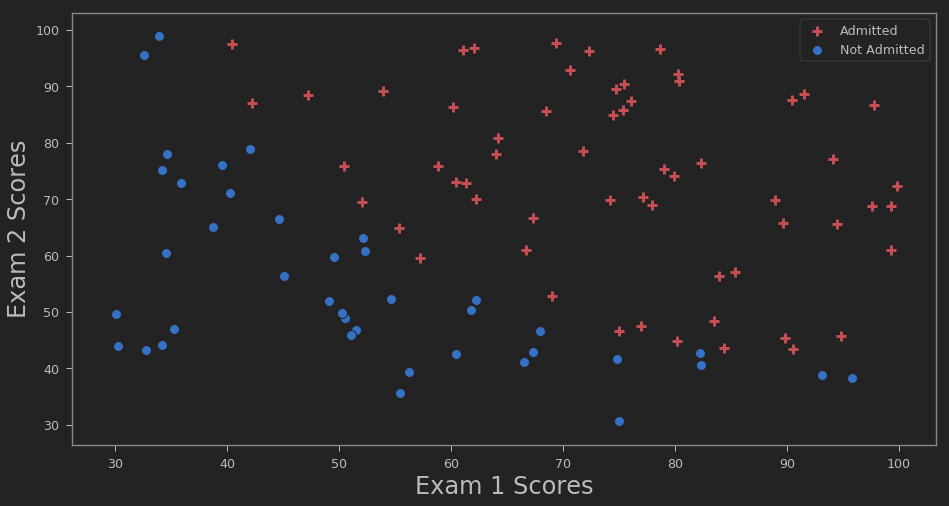

In [4]:
# Import Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import warnings
warnings.filterwarnings('ignore')
from jupyterthemes import jtplot
jtplot.style(theme='monokai',context='notebook',ticks=True,grid=False)

# Set the data location
dataDir = "./assignment/ex2/"
dataFile = "ex2data1.txt"
dataPath = dataDir+dataFile

# Load the data
data = pd.read_csv(dataPath,header=None).values
X = data[:,:-1]
y = data[:,-1]
m = len(y)

# Find the positive/negative cases
pos = np.argwhere(y==1)
neg = np.argwhere(y==0)

# Create the plot of the training data
fig = plt.figure(figsize=(12,6));
ax = fig.add_axes([0,0,1,1]);
ax.scatter(X[pos,0],X[pos,1],color='r',marker="+",edgecolor="k",linewidth=3,s=100);
ax.scatter(X[neg,0],X[neg,1],color='b',marker="o",edgecolor="k",linewidth=1,s=100);
ax.set_xlabel('Exam 1 Scores',fontsize=24);
ax.set_ylabel('Exam 2 Scores',fontsize=24);
ax.legend(("Admitted","Not Admitted"));

### Implementation

Recall that the cost function and gradients are

$$ 
J(\theta) = - \frac{1}{m} \Big( \sum_{i=1}^m y^{(i)} \log(h_\theta(x^{(i)})) + (1-y^{(i)}) \log(1 - h_\theta(x^{(i)})) \Big)
$$

and

$$
\begin{align}
\theta_j & := \theta_j - \alpha \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)} \\
\end{align}
$$

or we can vectorize via 

$$
\theta := \theta - \frac{\alpha}{m} X^T (g(X \theta) - y)
$$

where $g$ is our sigmoid function.

Now let's create some functions that we will use to calculate our cost function, as well as a function to call the BFGS algorithm to minimize the cost function on our parameters and a function to predict the results for a given input. 

In [5]:
def sigmoid(z):
    
    """Calculate the value of the sigmoid function for a given input"""
    
    # Return the sigmoid function
    return (1.0 / (1.0 + np.exp(-z)))

def cost(theta,X,y):
    
    """Calculate the cost function for logistic regression"""
    
    # Get number of training samples
    m = len(y)
    
    # Calculate the hypothesis function
    h = sigmoid(np.matmul(X,theta))
    
    # Calculate the cost function
    return (1.0/m)*(np.matmul(-y.T,np.log(h)) - np.matmul((1.0-y).T,np.log(1.0-h)))

def gradient(theta,X,y):
    
    """Calculate the gradient terms of the cost function"""
    
    # Get number of training samples
    m = len(y)
    
    # Calculate the hypothesis function
    h = sigmoid(np.matmul(X,theta))
    
    # Calculate the gradient
    return (1.0/m)*(np.matmul(X.T,(h-y)));

def minimize(cost,gradient,theta,args):

    """Use the scipy optimize BFGS minimization function to minimize the cost function"""
    
    # Set up the arguments
    f = cost
    x0 = theta
    fprime = gradient
    args = args

    # Return the minimized parameters
    return optimize.fmin_bfgs(f,x0,fprime,args)

def predict(theta,X):
    
    """Plug in a set of parameters, theta, and get the predicted results"""
    p = sigmoid(np.matmul(X,theta))
    p[np.where(p>=0.5)] = 1
    p[np.where(p<0.5)] = 0
    return(p)

Let's calculate the cost function for a trivial initial guess

In [6]:
# Add the extra column of ones to X and initiate theta parameters
X = data[:,:-1]
y = data[:,-1]
m,n = X.shape
X = np.concatenate((np.ones((m,1)),X),axis=1)
initialTheta = (np.zeros(n+1))

# Test the cost function and gradient functions on this initial guess
J = cost(initialTheta,X,y)
grad = gradient(initialTheta,X,y)

# Minimize the gradient using BFGS from scipy
result = minimize(cost,gradient,initialTheta,(X,y))

# Predict the admission results on the training dataset
p = predict(result,X)
percentage = 100.0*float(sum(p==y))/float((len(p)))
print("\nThe training set accuracy on the algorithm is {:0.2f}%".format(percentage))

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 23
         Function evaluations: 31
         Gradient evaluations: 31

The training set accuracy on the algorithm is 89.00%


### Plotting the Decision Boundary

We can now plot our line for the decision boundary overlaid on the training dataset.

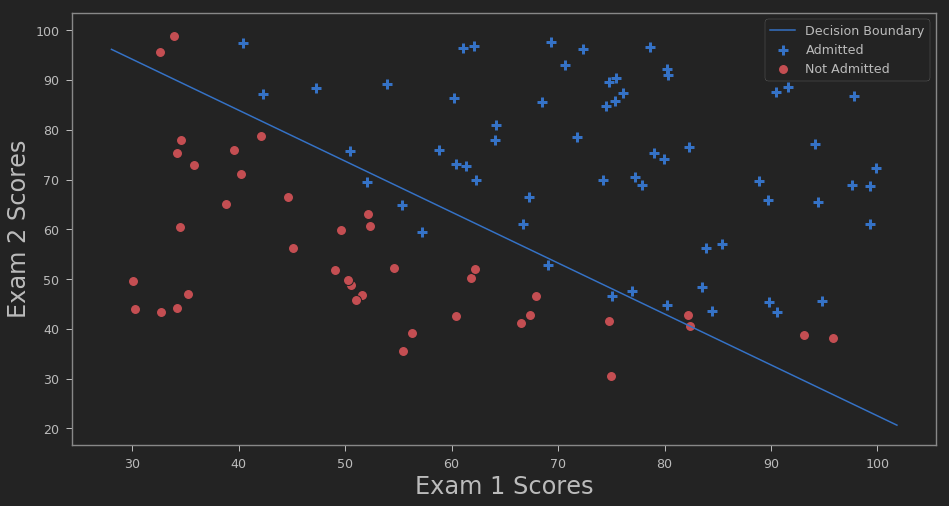

In [8]:
# Get the x and y values to plot
x = np.array([X[:,1].min()-2,X[:,1].max()+2])
y = (-1./result[2])*(result[1]*x+result[0])

# Create the plot of the training data
fig = plt.figure(figsize=(12,6));
ax = fig.add_axes([0,0,1,1]);
ax.scatter(X[pos,1],X[pos,2],color='b',marker="+",edgecolor="k",linewidth=3,s=100);
ax.scatter(X[neg,1],X[neg,2],color='r',marker="o",edgecolor="k",linewidth=1,s=100);
plt.plot(x,y);
ax.set_xlabel('Exam 1 Scores',fontsize=24);
ax.set_ylabel('Exam 2 Scores',fontsize=24);
ax.legend(("Decision Boundary","Admitted","Not Admitted"));

## Logistic Regression with Regularization
In this part of the exercise, you will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly. Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

### Visualizing the Data
Let's first load and plot the data.

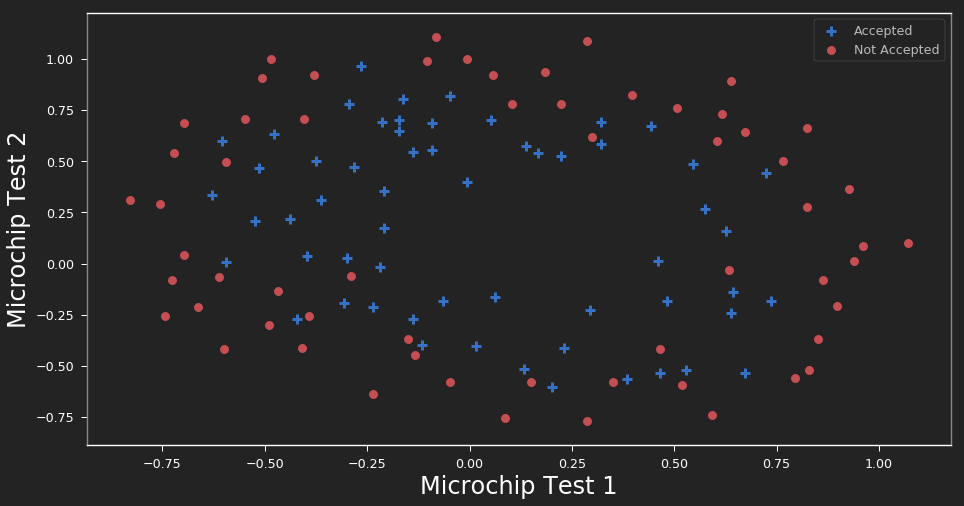

In [15]:
# Set the data location
dataDir = "./assignment/ex2/"
dataFile = "ex2data2.txt"
dataPath = dataDir+dataFile

# Load the data
data = pd.read_csv(dataPath,header=None).values
X = data[:,:-1]
y = data[:,-1]
m = len(y)

# Find the positive/negative cases
pos = np.argwhere(y==1)
neg = np.argwhere(y==0)

# Create the plot of the training data
fig = plt.figure(figsize=(12,6));
ax = fig.add_axes([0,0,1,1]);
ax.scatter(X[pos,0],X[pos,1],color='b',marker="+",edgecolor="k",linewidth=3,s=100);
ax.scatter(X[neg,0],X[neg,1],color='r',marker="o",edgecolor="k",linewidth=1,s=100);
ax.set_xlabel('Microchip Test 1',fontsize=24);
ax.set_ylabel('Microchip Test 2',fontsize=24);
ax.legend(("Accepted","Not Accepted"));
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='y', colors='white')

### Feature Mapping
Clearly, a linear fit will not work well here. Since we're using regularization, let's map the two features to a polynomial up to degree six. Regularization will then knock down the values of the parameters attached to the poor polynomials. We need to map each of the features to a new feature for each of the polynomial elements. The result of feature mapping to a 6 degree polynomial will resemble the following new matrix:

$$ X = \begin{bmatrix} 1 \\ x_1 \\ x_2 \\ x_1^2 \\ x_1 x_2 \\ x_2^2 \\ x_1^3 \\ \vdots \\ x_1 x_2^5 \\ x_2^6 \end{bmatrix} $$

In [16]:
X = data[:,:-1]
def feature_mapping(x1,x2,degree):
    
    """Take two features and return polynomial combinations of the two features"""

    # Set up array of ones for the 0th degree polynomial
    m = len(x1)
    n = 1
    X = np.ones((m,1)).squeeze()
    
    # Loop through all perturbations of the polynomial
    for i in range(1,degree+1):
        for j in range(0,i+1):
            A = ((x1**(i-j))*(x2**j)).T;
            if m != 1:
                X = np.concatenate((X,A))
            else:
                X = A
            n = n+1
            
    return X.reshape((n,m)).T

# Run the feature mapping function to get new X array
X = feature_mapping(X[:,0],X[:,1],6)

### Cost Function and Gradient

With regularization, our cost function is 

$$
J (\theta) = \frac{1}{2 m} \sum_{i=1}^m \Big( h_\theta (x^{(i)} - y^{(i)} \Big)^2 + \lambda \sum_{j=1}^n \theta_j^2
$$

and the regularized gradient is 

$$
\begin{align}
    \theta_0 & := \theta_0 - \alpha \frac{1}{m} \sum_{i=1}^m \Big( h_\theta (x^{(i)}) - y^{(i)} \Big) x_0^{(i)} \\
    \theta_j & := \theta_j - \alpha \frac{1}{m} \sum_{i=1}^m \Big( h_\theta (x^{(i)}) - y^{(i)} \Big) x_j^{(i)} + \frac{\lambda}{m} \theta_j,  \text{ for } j \in \{1,2,\cdots,n\} \\
    & := \theta_j(1-\alpha\frac{\lambda}{m}) - \alpha\frac{1}{m} \sum_{i=1}^m \Big( h_\theta (x^{(i)}) - y^{(i)} \Big) x_j^{(i)}
\end{align}
$$

So now we need to modify our functions to compute the cost function and gradients.

In [17]:
def regularized_cost(theta,X,y,regCoeff):
    
    """Calculate the regularized cost function for logistic regression"""
    
    # Get number of training samples
    m = len(y)
    
    # Calculate the hypothesis function
    h = sigmoid(np.matmul(X,theta))
    
    # Calculate the unregularized cost function
    J = (1.0/m)*(np.matmul(-y.T,np.log(h)) - np.matmul((1.0-y).T,np.log(1.0-h)))
    
    # Returen the regularized cost function 
    return J + (regCoeff/(2.0*m))*(np.dot(theta[1:],theta[1:]))

def regularized_gradient(theta,X,y,regCoeff):
    
    """Calculate the regularized gradient terms of the cost function"""
    
    # Get number of training samples
    m = len(y)
    
    # Calculate the hypothesis function
    h = sigmoid(np.matmul(X,theta))
    
    # Calculate the unregularized gradient
    grad = (1.0/m)*(np.matmul(X.T,(h-y)));
    
    # Return the regularize gradient
    grad[1:] = grad[1:]+((regCoeff/m)*(theta[1:]));
    return grad

### Implementation

Now, the implementation looks the same as before, but we'll use the regularized functions in our BFGS function call.

In [18]:
# Set the regularization coefficient and initiate theta parameters
regCoeff = 1.0
m,n = X.shape
initialTheta = np.zeros(n)

# Test the cost function and gradient functions on this initial guess
J = cost(initialTheta,X,y)
J = regularized_cost(initialTheta,X,y,regCoeff)
grad = regularized_gradient(initialTheta,X,y,regCoeff)

# Minimize the gradient using BFGS from scipy
result = minimize(regularized_cost,regularized_gradient,initialTheta,(X,y,regCoeff))

# Predict the admission results on the training dataset
p = predict(result,X)
percentage = 100.0*float(sum(p==y))/float((len(p)))
print("\nThe training set accuracy on the algorithm is {:0.2f}%".format(percentage))

Optimization terminated successfully.
         Current function value: 0.529003
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48

The training set accuracy on the algorithm is 83.05%


### Plotting the Decision Boundary

We can now plot our line for the decision boundary overlaid on the training dataset.

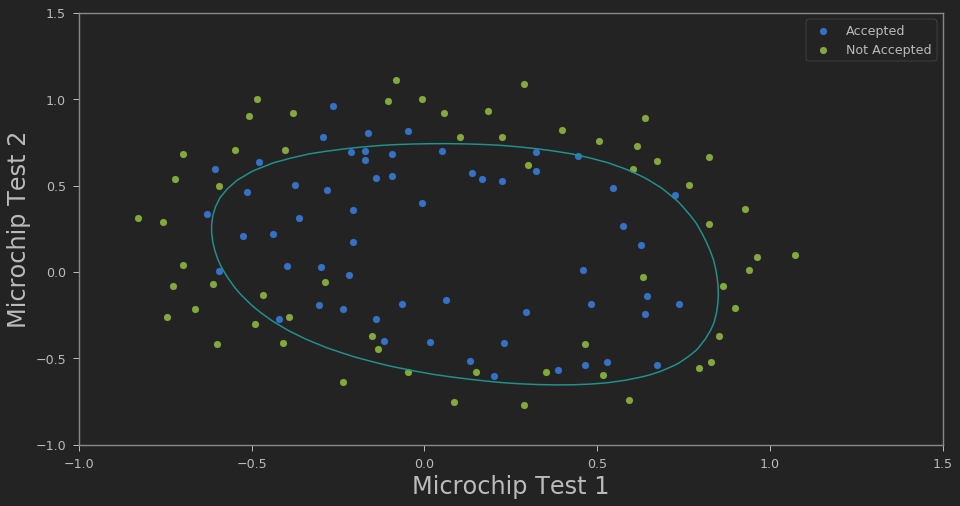

In [19]:
## Create the grid
u = np.linspace(-1, 1.5, 50)
v = np.linspace(-1, 1.5, 50)
z = np.zeros((len(u), len(v)))

# Map features to our 6 degree polynomial for plotting 
def mapFeatureForPlotting(X1, X2):
    degree = 6
    out = np.ones(1)
    for i in range(1, degree+1):
        for j in range(i+1):
            out = np.hstack((out, np.multiply(np.power(X1, i-j), np.power(X2, j))))
    return out

# Calculate the optimized boundary line function
for i in range(len(u)):
    for j in range(len(v)):
        z[i,j] = np.dot(mapFeatureForPlotting(u[i], v[j]),result)
        
# Create a mask for the data to separate positive and negative
mask = y.flatten() == 1

# Reload the data
data = pd.read_csv(dataPath, header = None)
X = data.iloc[:,:-1]
y = data.iloc[:,2]

# Plot the data
fig = plt.figure(figsize=(12,6));
ax = fig.add_axes([0,0,1,1]);
passed = ax.scatter(X[mask][0], X[mask][1])
failed = ax.scatter(X[~mask][0], X[~mask][1])
ax.contour(u,v,z,0)
ax.set_xlabel('Microchip Test 1',fontsize=24);
ax.set_ylabel('Microchip Test 2',fontsize=24);
ax.legend(("Accepted","Not Accepted"));